<h1>Plot Tweet Timelines Using Bins and Interactive Bokeh Scatterplots</h1>
<p>For this lesson we will generate timeline plots of individual tweets and all retweets for the most retweeted tweets using 5 minute (variable) bins and interactive Bokeh scatterplots with Botometer scores and follower counts. </p>

<h2>About the Data</h2>
<p>This dataset was created earlier this year using the Twitter Streaming API searching for all tweets/retweets which use the hashtag 'muellerreport'. The original data was collected in its native JSON format. The JSON data comprised more than 5 GB. We reduced the size by extracting a subset of features, only a few of which we will need for this lesson. Here are some stats for the dataset. </p>
<p>Start: 2019-04-09 17:59:58</p>
<p>End: 2019-04-29 15:24:59</p>
<p>1,732,899 Total Tweets</p>
<p>1,420,964 Retweets</p>
<p>311,935 Original Tweets</p>

In [2]:
# import packages
import datetime
import math
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from math import exp, expm1
from bokeh.io import export_png, output_notebook
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool
from pprint import pprint
pd.options.display.max_colwidth = 350

In [3]:
hashtag = 'muellerreport'

<h1>Using PKL For Input</h1>

In [4]:
df = pd.read_pickle('data/pkl/muellerreport_tweets_set2.pkl')

In [5]:
df.head()

,tweet_id,tweet_created_at,language,user_screen_name,user_created_at,user_id,user_description,followers_count,friends_count,time_zone,utc_offset,is_quote_status,retweeted_status,retweet_id,retweet_user_screen_name,retweet_user_id,text
0,1115675738122878976,2019-04-09 17:59:58,en,charleygirl1234,2019-04-09 17:59:58,857032075014230016,NaN,250,319,NaN,NaN,False,1,1115672911128420352,dnarip,88984389,LOLOLOL #AGBarr tells Dems to get bent on releasing the entire #MuellerReport \n\nhttps://t.co/svlSZWrFtw
1,1115675753826353152,2019-04-09 18:00:02,en,TrumperSeaney,2019-04-09 18:00:02,1049814472817344512,🇺🇲 America loving patriot! 🇺🇲@realDonaldTrump is the #BestPresidentEver! #SocialismKills #DemocratsAreDomesticTerrorists!,16513,8910,NaN,NaN,False,1,1115670376443457542,darhar981,187936720,#BillBarr Crushes #Democrat Hopes Again on #MuellerReport: My Letter About #NoCollusion or #Obstruction Speaks for Itself....\n#POTUS\n#Trump2020Landslide \n#KAG2020\n#MAGA\n#WomenForTrump\n👇🏻👇🏻👏🏽👏🏽👏🏽👏🏽👏🏽👏🏽👇🏻👇🏻\nhttps://t.co/HhdjHMeHjo
2,1115675775062007808,2019-04-09 18:00:07,en,ImmoralReport,2019-04-09 18:00:07,3376927462,#StopAbortion #StopGayMarriage #StopIllegalAliens #BuildTheWall #SecureTheBorder #DeportThemAll #HillaryForPrison #NoLibtards #FollowPatriots #TrumpTrain #KAG,30859,30261,NaN,NaN,False,1,1115674843620478976,PaulModica777,850786007603609600,@halcatt @RealJamesWoods Straight up #Truth \n#LockHerUp #HillaryForPrison #BillClintonIsARapist #AuditTheClintonFoundation #ClintonBodyCount #UraniumOne #SethRich #Benghazi #Haiti #Libya #Syria #ObamaForPrison #IRSGate #FastAndFurious #PedoGate #BigTechGate #SpyGate #MuellerReport #Antifa #BLM
3,1115675777297715203,2019-04-09 18:00:08,en,GorgonsonnSon,2019-04-09 18:00:08,858760555607326721,NaN,2378,3498,NaN,NaN,False,0,None,None,None,@darrengrimes_ Ah. Oh dear. How sad. Never mind.\n\n#StopBrexit\n#StopBrexitSaveBritain\n#MuellerReport\n#electionfraud https://t.co/qdTaFQktJH
4,1115675808075534337,2019-04-09 18:00:15,en,KPBSnews,2019-04-09 18:00:15,9601512,"We cover politics, education, health, environment, the border and more on radio (89.5FM), TV and online. https://t.co/uw6dQenvZe",67655,3919,NaN,NaN,False,0,None,None,None,"As the release of the #MuellerReport looms, President Donald Trump launches a renewed attack on the special counsel. https://t.co/P2tZLvkJ8S https://t.co/bnNYgYIpMg"


<h2>Extract Retweets</h2>
<p>Next, we need to work only with retweets. These are the tweets with retweeted_status = 1. </p>

In [6]:
retweet_df = df[df.retweeted_status != 0]

<h2>Generate Top Retweets, Top Retweeted, and Top Retweeters in the Dataset.</h2>
<p>For this lesson we need the top retweeted tweets and the top retweeters in the dataset. Just for grins, we also generate a dataframe containing a list of the Twitter users who were retweeted the most in this dataset. This should give us an idea about some of the more interesting features of the dataset. </p>

In [7]:
topretweets = retweet_df[retweet_df.retweeted_status != 0].groupby('retweet_id').size().sort_values(ascending=False).reset_index()
topretweeters = retweet_df[retweet_df.retweeted_status != 0].groupby('user_screen_name').size().sort_values(ascending=False).reset_index()
topretweeted = retweet_df[retweet_df.retweeted_status != 0].groupby('retweet_user_screen_name').size().sort_values(ascending=False).reset_index()

The feature we are interested in for this lesson is those tweets which were retweeted the most in the dataset, including their retweet count. Let's look at the first 5 rows of the top retweeted tweets.

In [8]:
topretweets.head()

,retweet_id,0
0,1118622847025336320,18401
1,1119345444759527424,15484
2,1118995355498995712,15469
3,1118883825550024705,14794
4,1118909240725385216,14267


The column named '0" contains the retweet counts. Let's rename that column.

In [9]:
topretweets = topretweets.rename(columns={0:'retweet_count'})

In [10]:
topretweets.head()

,retweet_id,retweet_count
0,1118622847025336320,18401
1,1119345444759527424,15484
2,1118995355498995712,15469
3,1118883825550024705,14794
4,1118909240725385216,14267


Let's do the same for the top retweeters.

In [11]:
topretweeters = topretweeters.rename(columns={0:'retweet_count'})

In [12]:
topretweeters.head()

,user_screen_name,retweet_count
0,Alpha_Omega_Yah,766
1,WordswithSteph,498
2,ActionTime,494
3,theMAGAbot,423
4,Solutioneer72,308


In [13]:
topretweeted = topretweeted.rename(columns={0:'retweet_count'})

In [14]:
topretweeted.head()

,retweet_user_screen_name,retweet_count
0,SpeakerPelosi,58583
1,RepSwalwell,52020
2,SaraCarterDC,32739
3,tedlieu,31835
4,RepDougCollins,27391


## Generate 'Binned' Plot For Entire Dataset
In this step we will use a 5 minute bin size and generate a binned frequency plot for the entire dataset. 

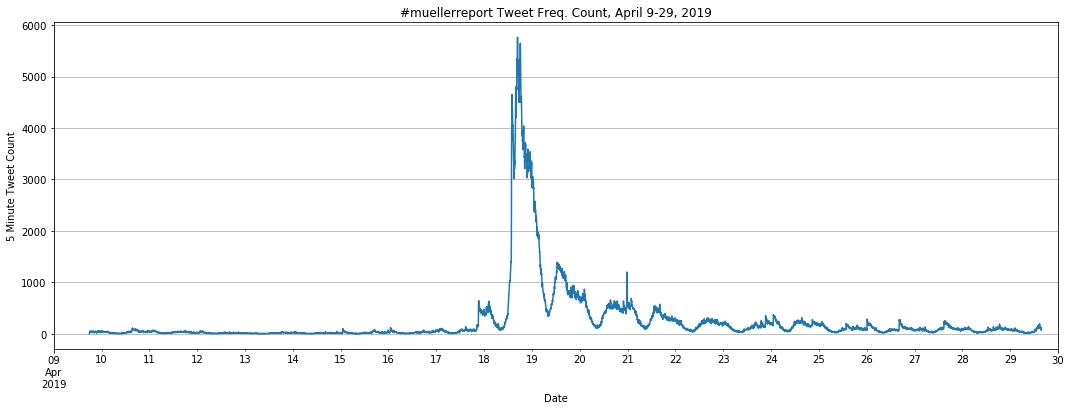

In [15]:
retweet_df.groupby(pd.Grouper(key='tweet_created_at', freq='5Min', convention='start')).size().plot(figsize=(18,6))
plt.xlabel('Date')
plt.ylabel('5 Minute Tweet Count')
plt.title('#' + hashtag + ' Tweet Freq. Count, April 9-29, 2019')
plt.xlim([datetime.date(2019, 4, 9), datetime.date(2019, 4, 30)])
plt.grid(True)
plt.savefig("images/binned_plots/" + hashtag + "_set2_all_tweets_freq_count_apr9_to_29_2019.png")
plt.show()

## Generate Individual 'Binned' or 'Frequency' Plots of Top Retweets
In this step we will generate one plot for each of the top retweeted tweets in the dataset. For these plots we will use a 5 minute bin size. 

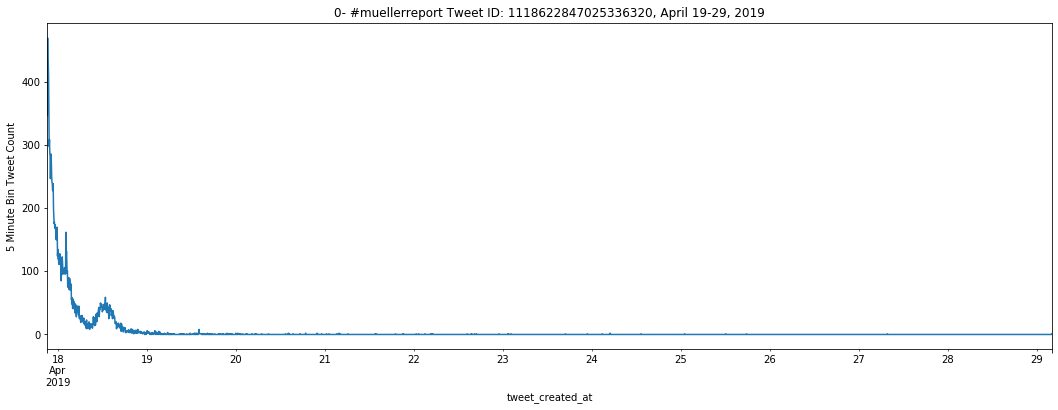

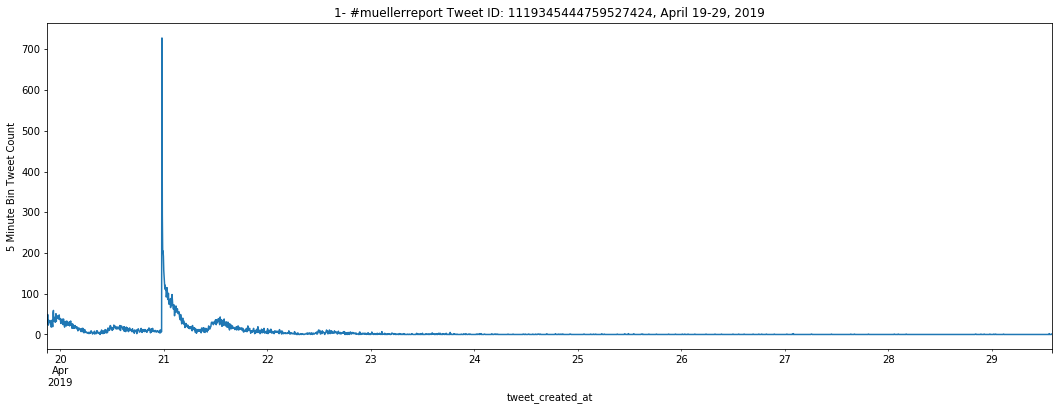

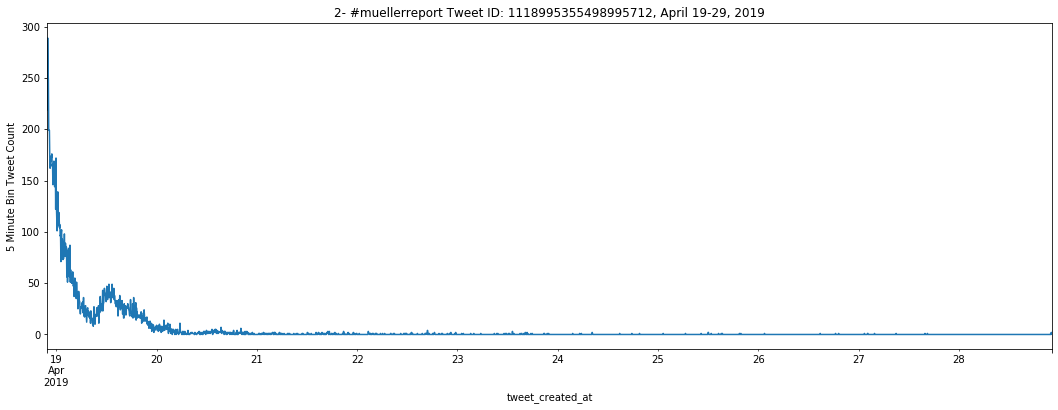

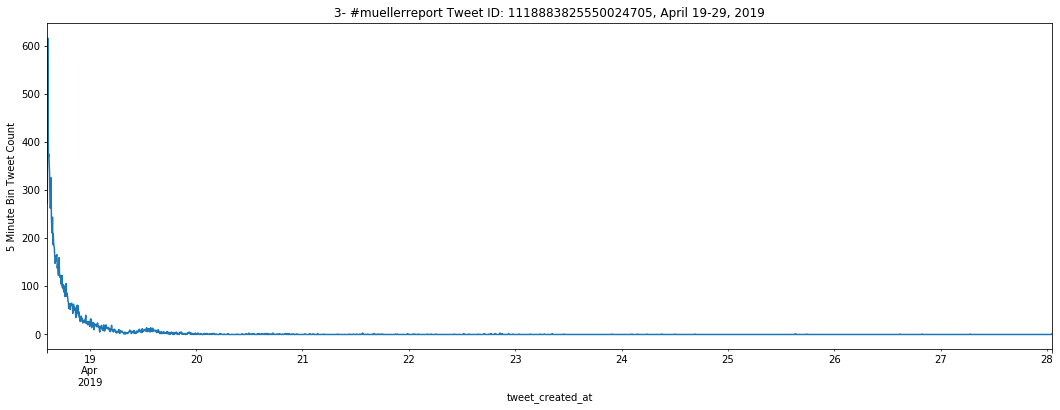

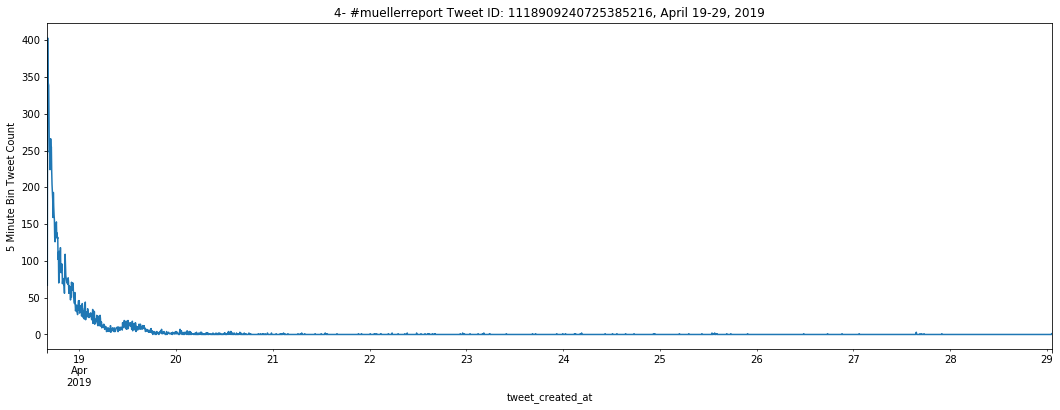

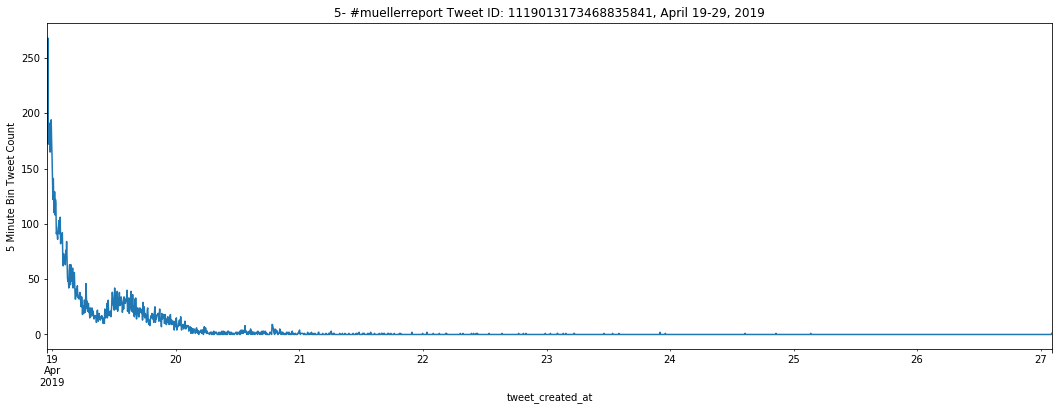

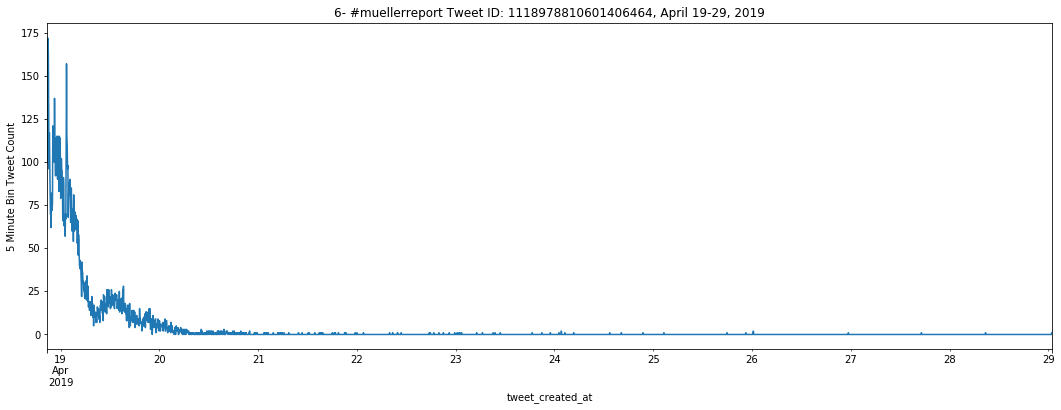

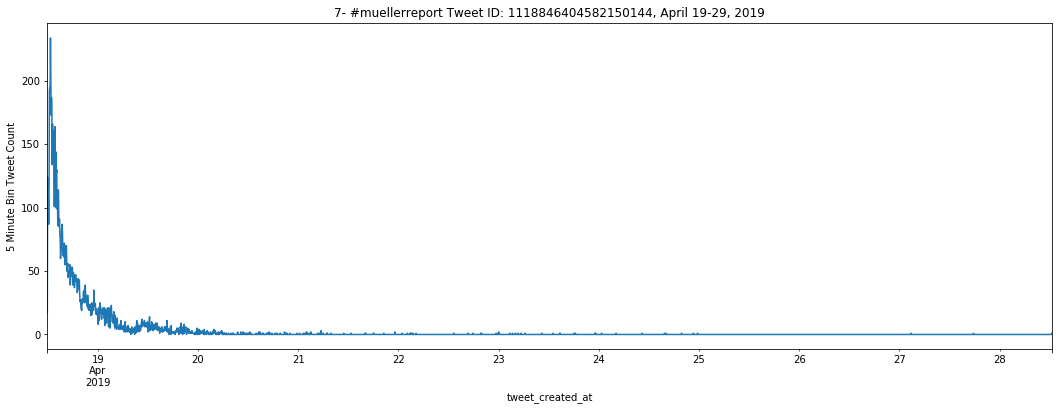

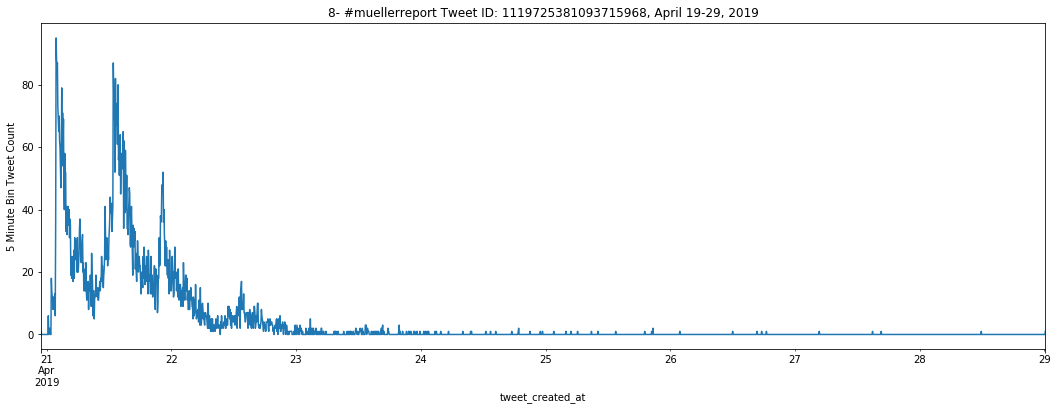

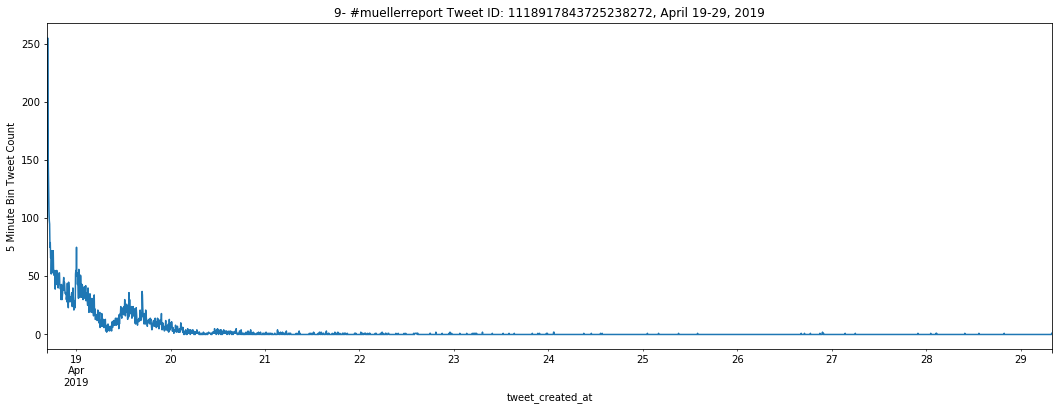

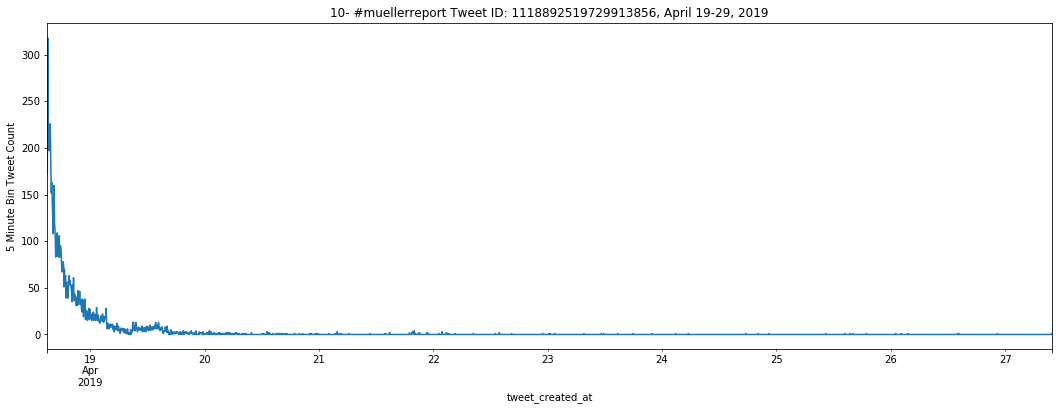

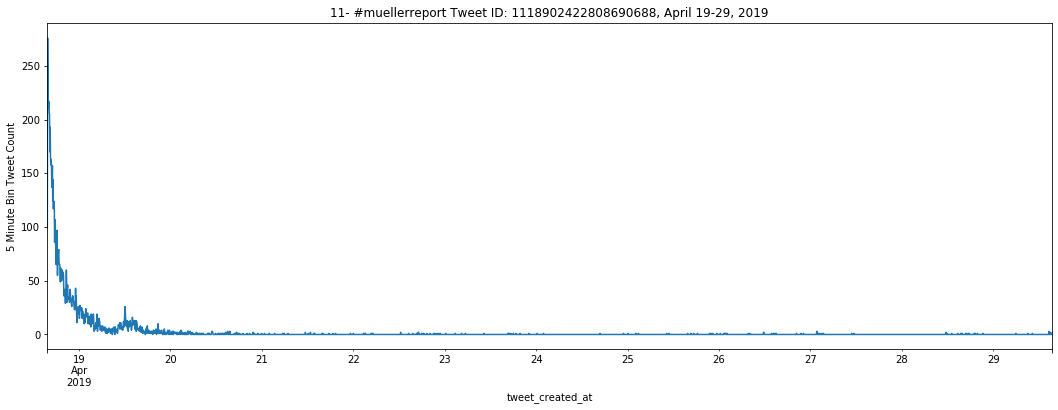

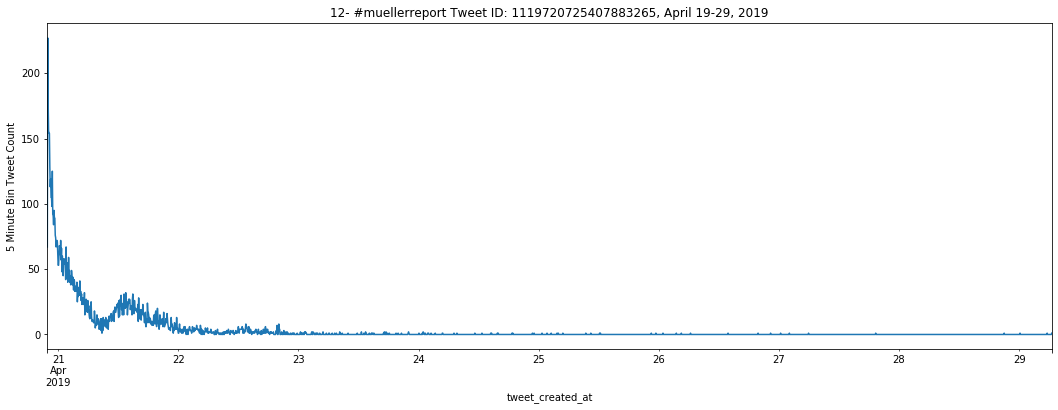

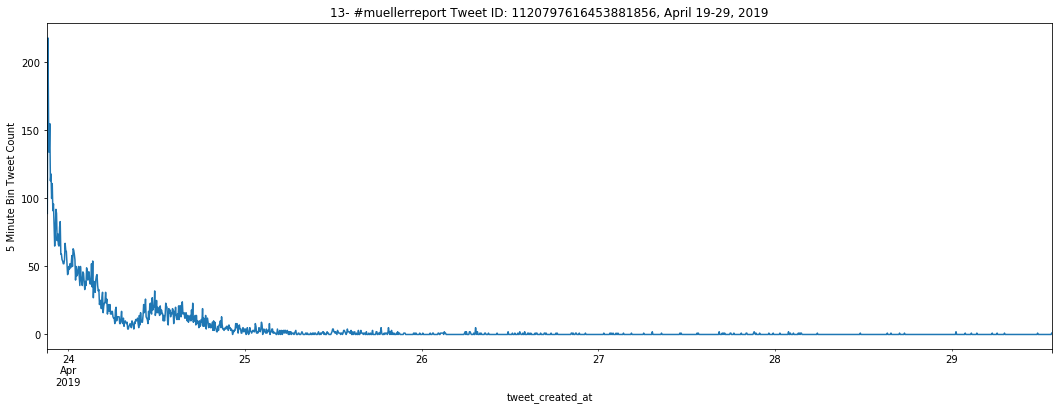

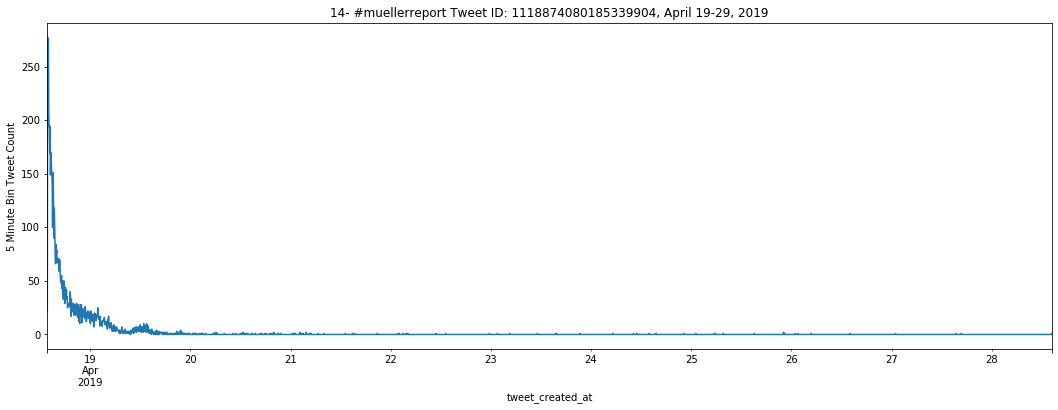

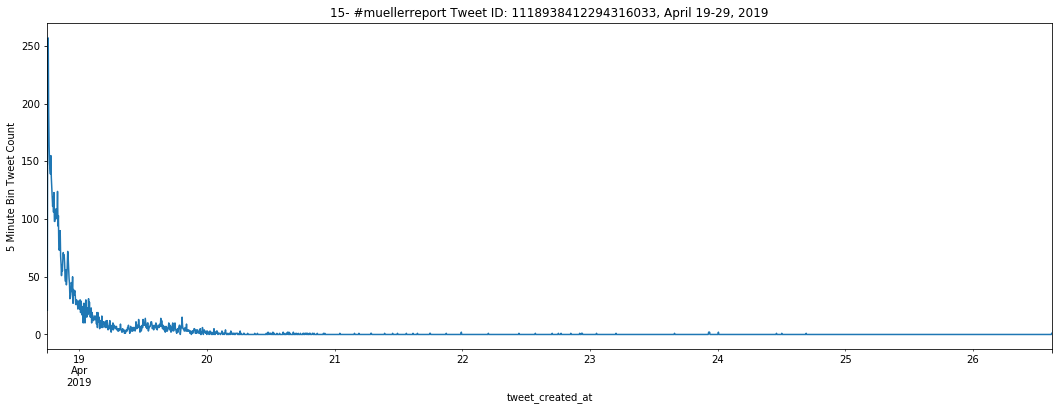

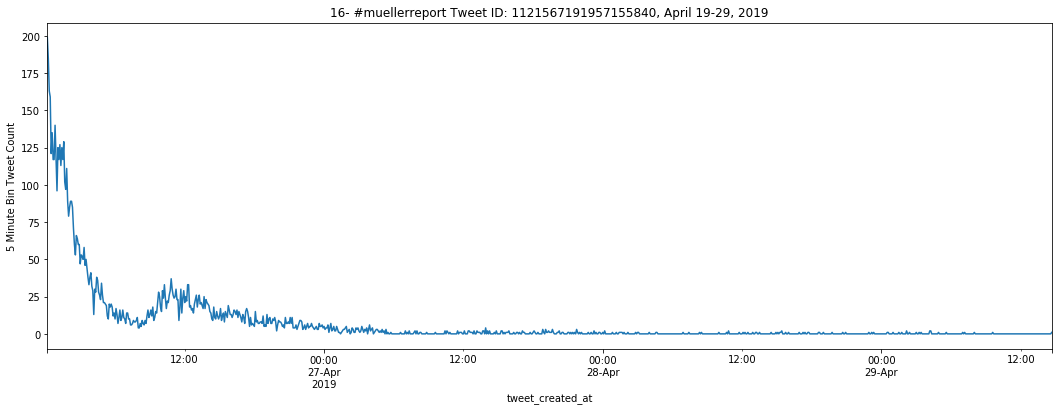

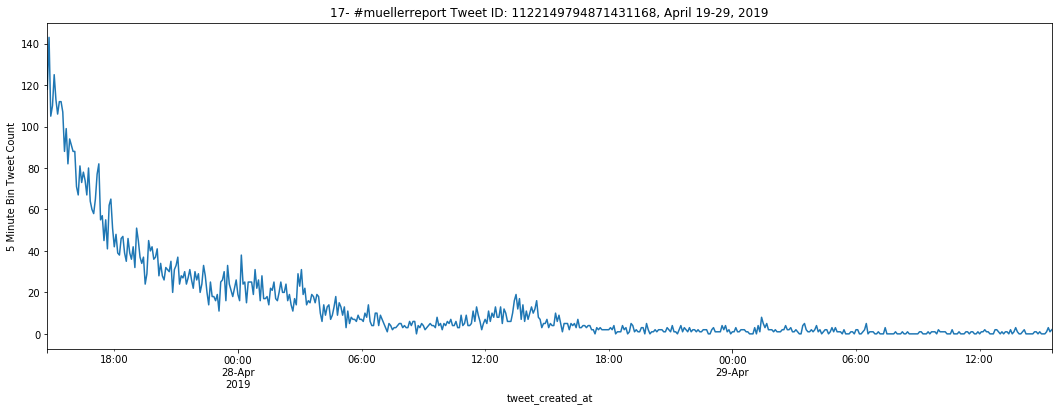

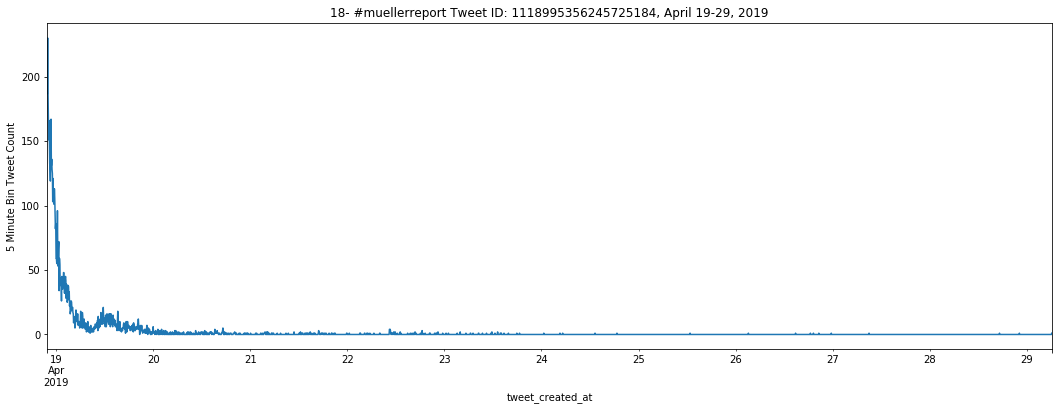

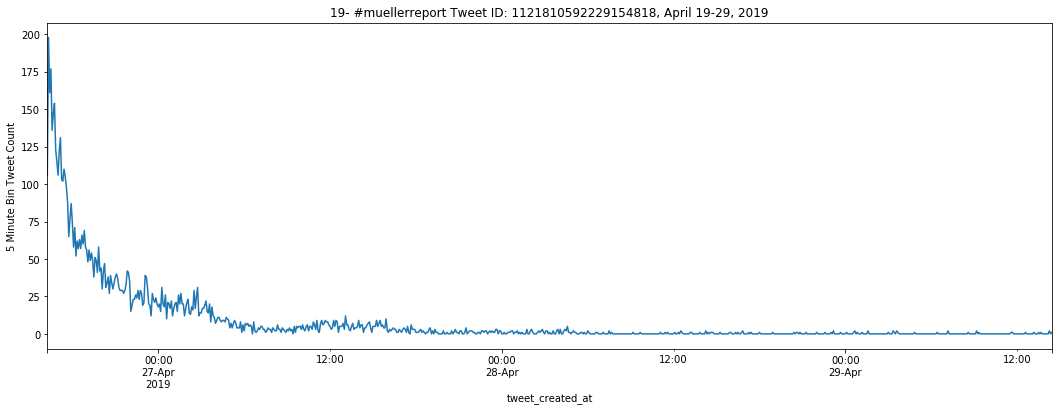

In [16]:
start_tweet = 0
end_tweet = 20
for top in range(start_tweet, end_tweet):
    tweetid = topretweets.iloc[top].retweet_id
    top_tweets = retweet_df[retweet_df.retweet_id==tweetid]
    plt.figure()
    top_tweets.groupby(pd.Grouper(key='tweet_created_at', freq='5Min', convention='start')).size().plot(figsize=(18,6))
    plt.ylabel('5 Minute Bin Tweet Count')
    plt.title(str(top) + '- #' + hashtag + ' Tweet ID: {}, April 19-29, 2019'.format(tweetid))
    plt.savefig("images/binned_plots/" + str(top) + "_" + hashtag + "_set2_tweet_" + str(tweetid) + "_binned_apr19_to_29_2019.png")

<h2>Generate Combined Plot of Top 20 Retweet Frequency Counts</h2>

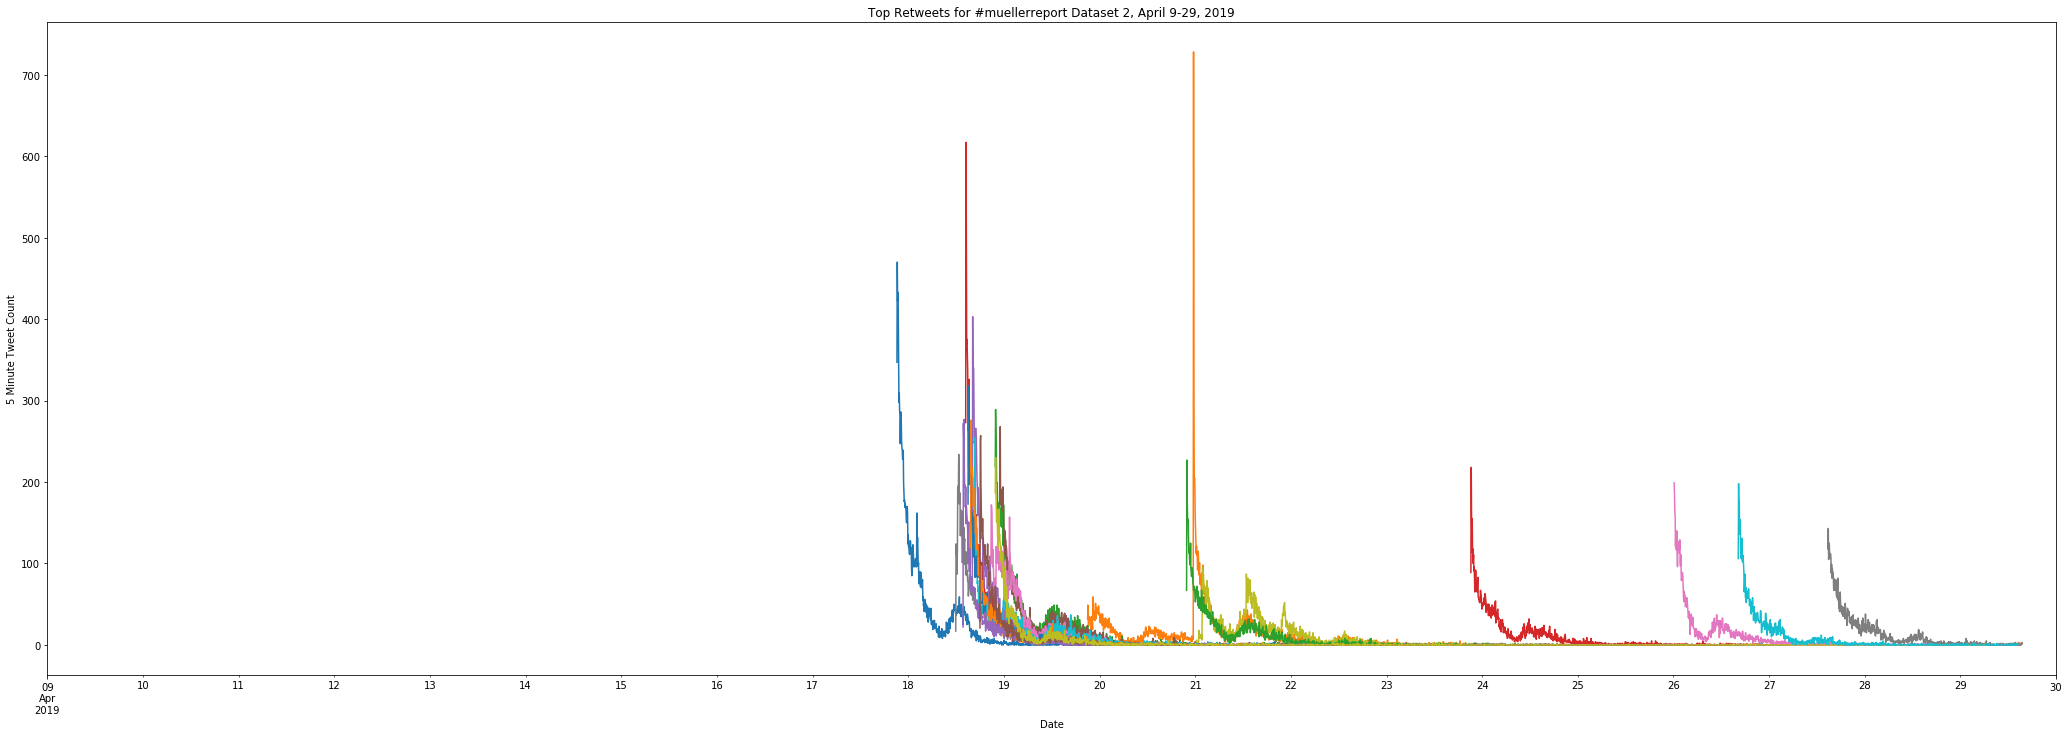

In [17]:
plt.figure(figsize=(36,12))
start_tweet = 0
end_tweet = 20
for top in range(start_tweet,end_tweet):
    tweetid = topretweets.iloc[top].retweet_id
    top_retweets = retweet_df[retweet_df.retweet_id==tweetid]
    top_retweets.groupby(\
        pd.Grouper(key='tweet_created_at', freq='5Min', convention='start')).size().plot()

plt.xlabel('Date')
plt.ylabel('5 Minute Tweet Count')
plt.title('Top Retweets for #' + hashtag + ' Dataset 2, April 9-29, 2019')
plt.xlim([datetime.date(2019, 4, 9), datetime.date(2019, 4, 30)])
plt.savefig("images/binned_plots/" + hashtag + "_top_retweet_timelines.png")
plt.show()

## Generate 'Cumulative Timelines' of Top Tweet Lifespans
Cumulative timelines are a novel method for using scatterplots to reveal features of retweet activity which may not be apparent in a binned plot. This method simply uses an integer increment for the y-axis, helping to reveal moments in a tweets life in which retweets surge or wane. 

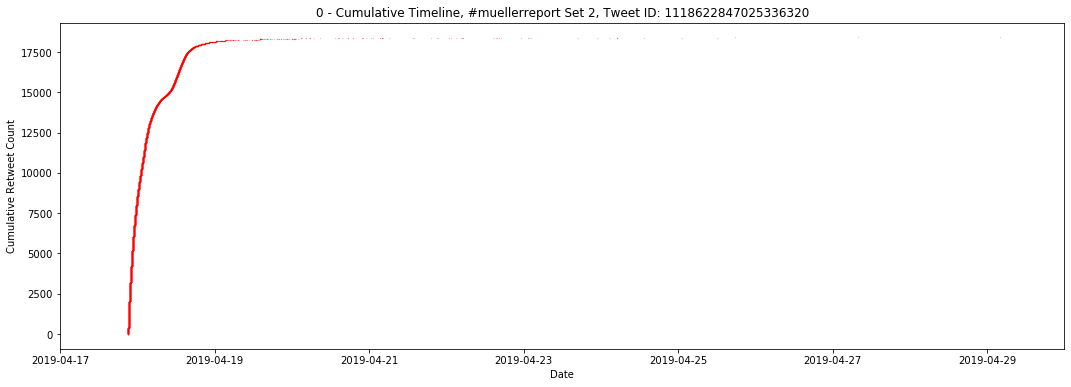

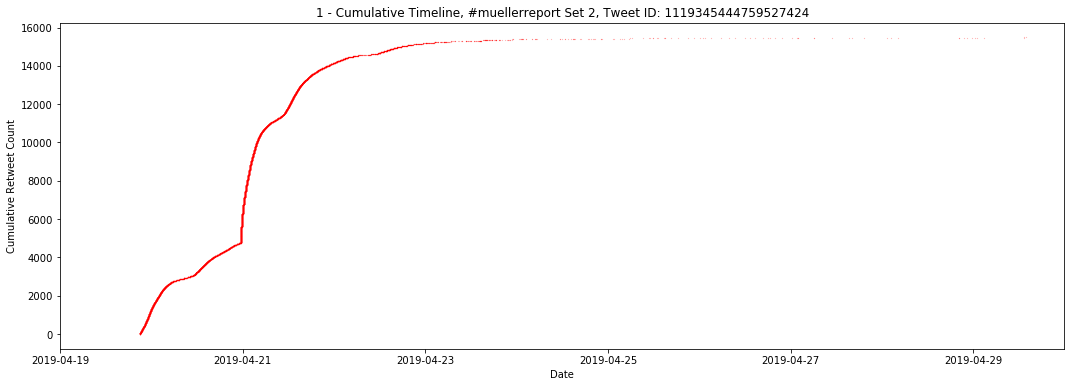

In [18]:
start_tweet = 0
end_tweet = 2
for top in range(start_tweet, end_tweet):
    
    # Get all retweets for tweetid
    tweetid = topretweets.iloc[top].retweet_id
    top_retweets = retweet_df[retweet_df.retweet_id==tweetid].sort_values('tweet_created_at').reset_index()
    
    # Create a list of dates for x axis
    values = list(x for x in top_retweets["tweet_created_at"])
    
    plt.figure(figsize=(18,6))
    plt.plot(top_retweets.tweet_created_at, top_retweets.index, 'ro', markersize=0.1)
    plt.xlim([datetime.date(values[0].year, values[0].month, values[0].day), datetime.date(2019, 4, 30)])
    plt.xlabel('Date')
    plt.ylabel('Cumulative Retweet Count')
    plt.title(str(top) + ' - Cumulative Timeline, #' + hashtag + ' Set 2, Tweet ID: ' + str(tweetid))
    plt.show()
    plt.savefig("images/cumulative_scatterplots/" + str(top) + "_" + hashtag + "_set2_tweet_" + str(tweetid) + "_scatter_v1_apr9_to_29_2019.png")
    plt.close()

<h2>Generate 'Cumulative Timelines' of Top Tweet Lifespans Scaled by Followers Count</h2>

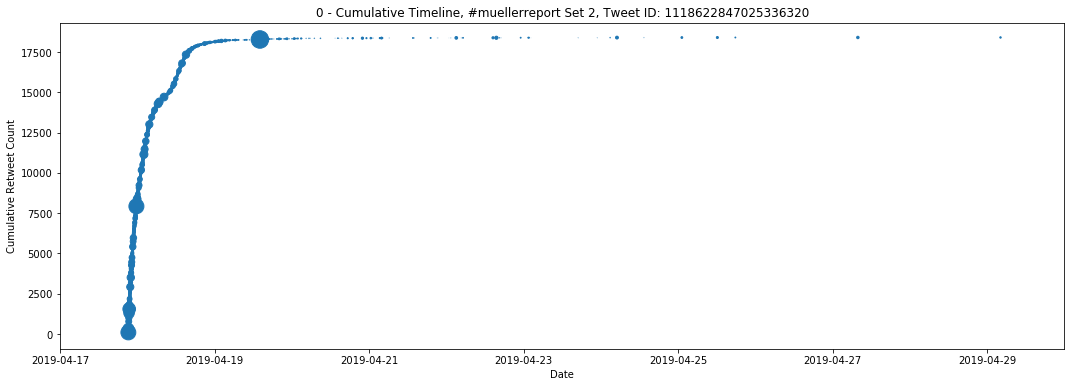

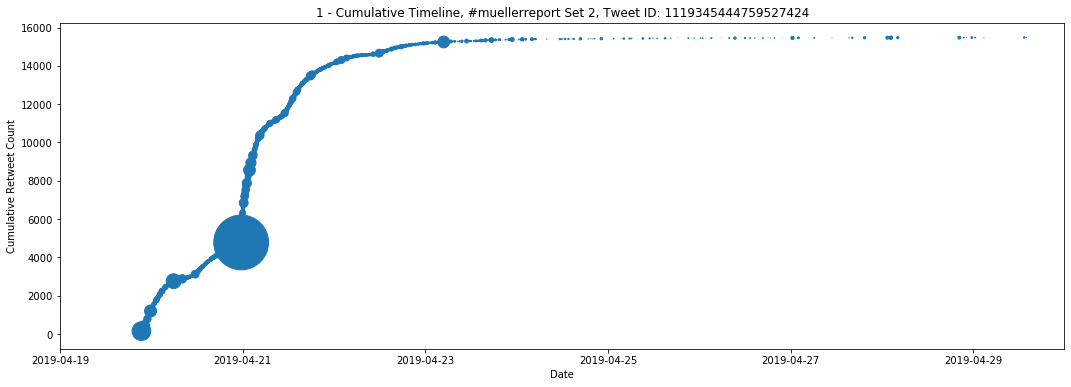

In [19]:
start_tweet = 0
end_tweet = 2
for top in range(start_tweet, end_tweet):
    
    # Get all retweets for tweetid
    tweetid = topretweets.iloc[top].retweet_id
    top_retweets = retweet_df[retweet_df.retweet_id==tweetid].sort_values('tweet_created_at').reset_index()
    
    # Create a list of datesfor x axis
    values = list(x for x in top_retweets["tweet_created_at"])

    # Create list of followers counts
    followers_count = list(f for f in top_retweets['followers_count'])
    followers_count_scaled = []
    for j in range(len(followers_count)):
        if followers_count[j] > 1000000:
            followers_count_scaled.append(3000)
        else:                
            followers_count_scaled.append(followers_count[j]/2000)
    
    plt.figure(figsize=(18,6))
    plt.scatter(top_retweets.tweet_created_at, top_retweets.index, s=followers_count_scaled)
    plt.xlim([datetime.date(values[0].year, values[0].month, values[0].day), datetime.date(2019, 4, 30)])
    plt.xlabel('Date')
    plt.ylabel('Cumulative Retweet Count')
    plt.title(str(top) + ' - Cumulative Timeline, #' + hashtag + ' Set 2, Tweet ID: ' + str(tweetid))
    plt.show()
    plt.savefig("images/cumulative_scatterplots/" + str(top) + "_" + hashtag + "_set2_tweet_" + str(tweetid) + "_scatter_v1_apr9_to_29_2019.png")
    plt.close()

<h2>Generate Combined Cumulative Timelines of Top Tweet Lifespans Scaled by Followers Count</h2>

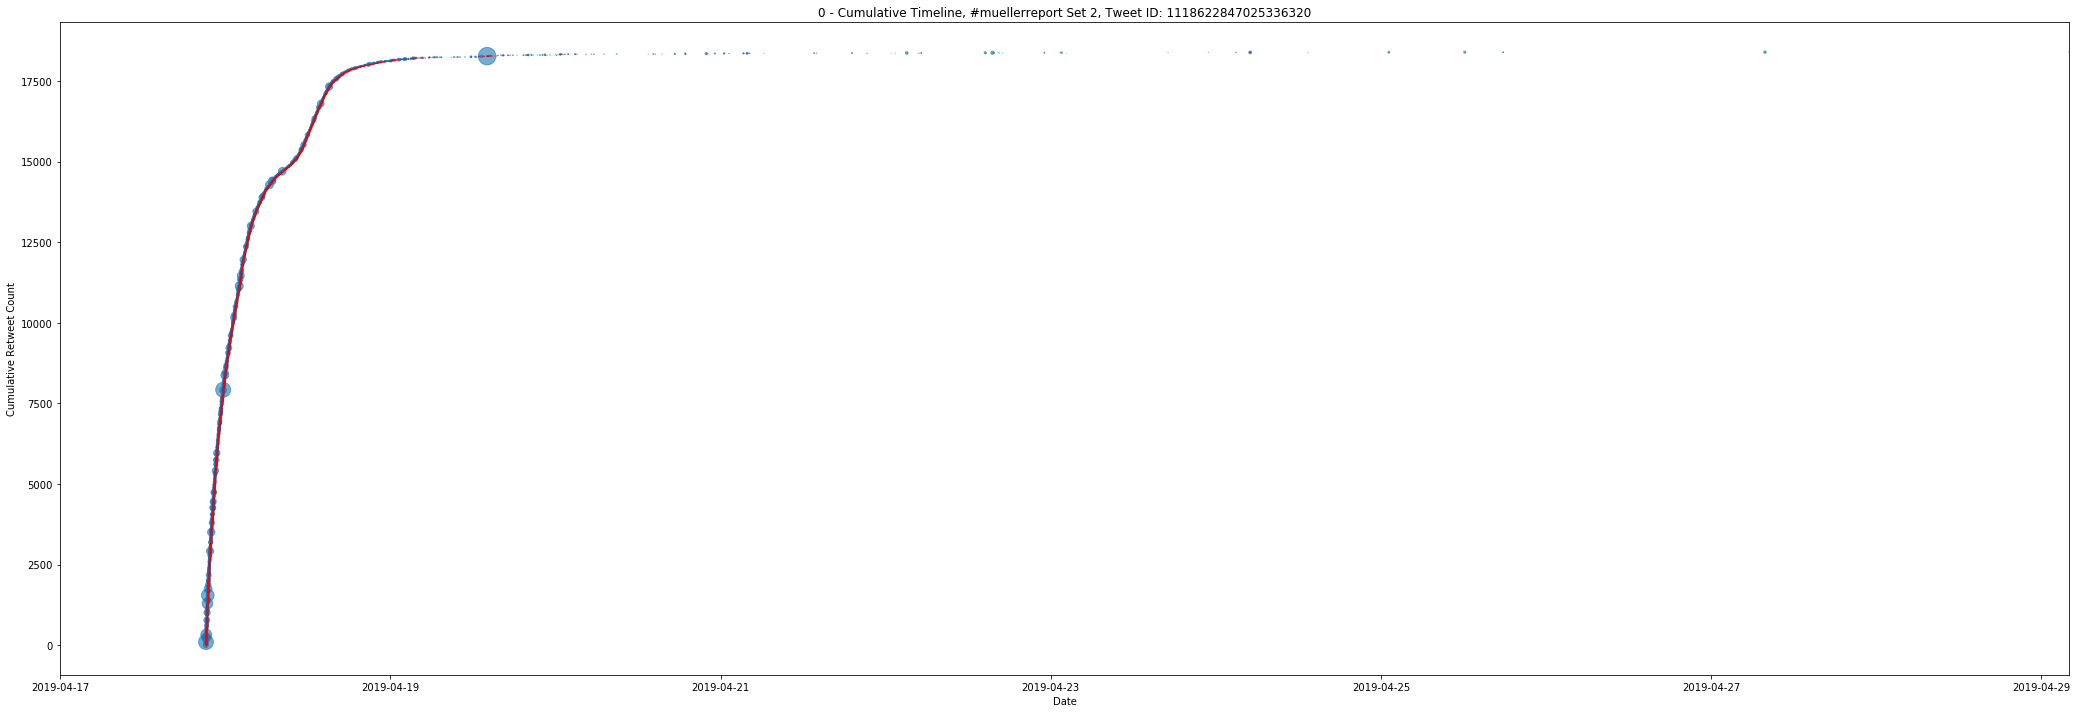

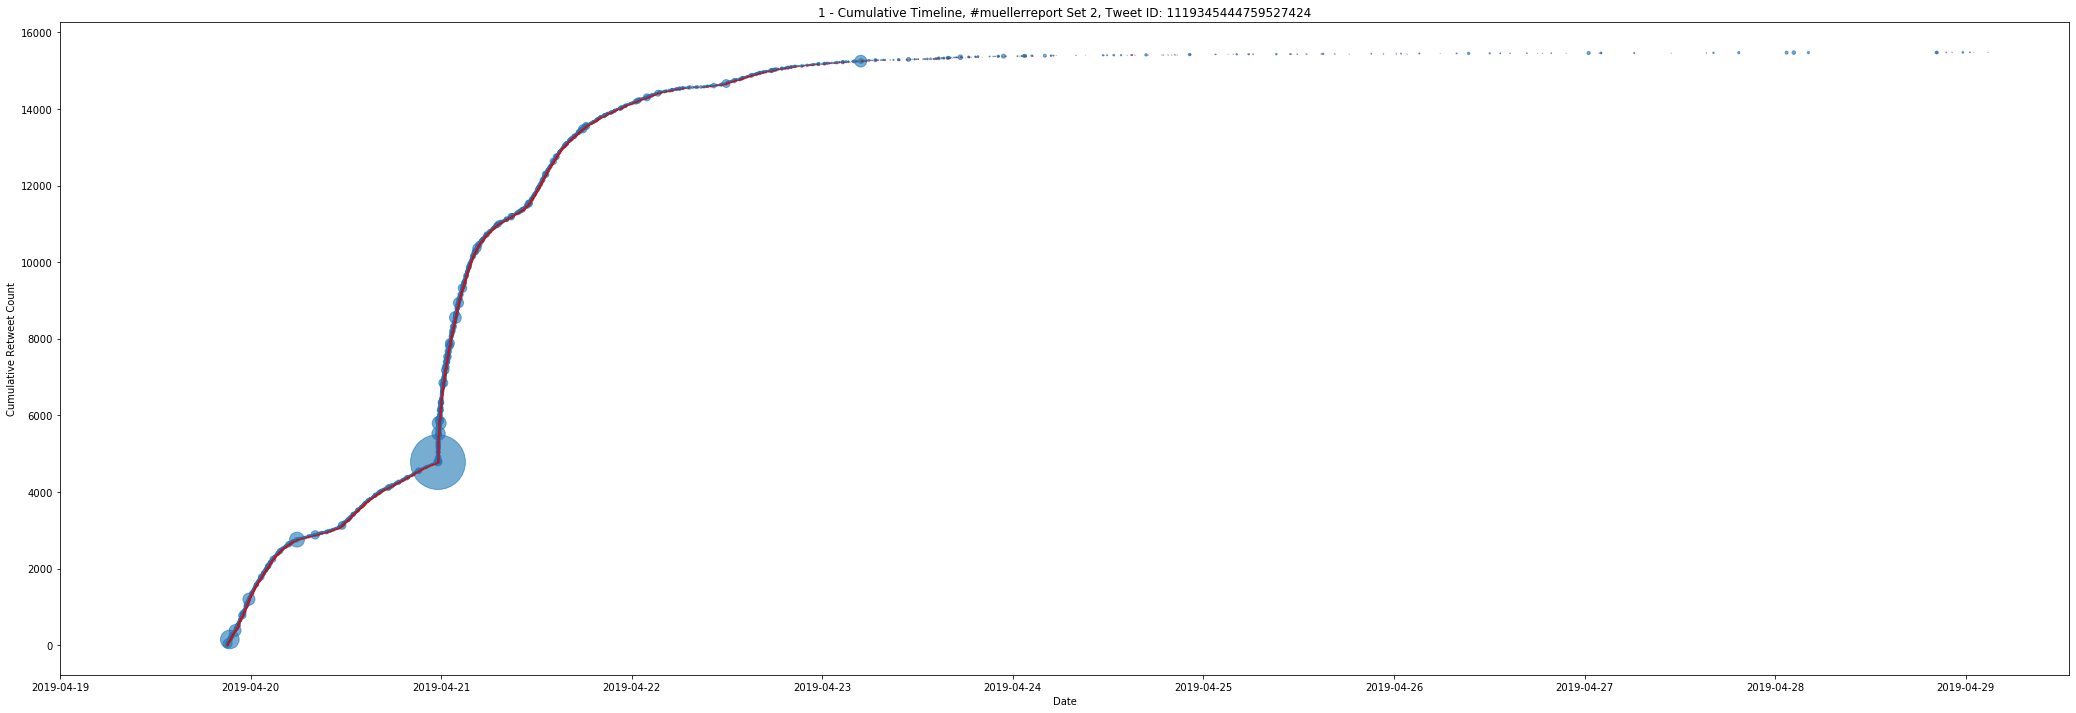

In [20]:
start_tweet = 0
end_tweet = 2
for top in range(start_tweet, end_tweet):
    
    # Get all retweets for tweetid
    tweetid = topretweets.iloc[top].retweet_id
    top_retweets = retweet_df[retweet_df.retweet_id==tweetid].sort_values('tweet_created_at').\
        reset_index()
    
    # Create a list of datesfor x axis
    values = list(x for x in top_retweets["tweet_created_at"])
    
    # Create list of followers counts
    followers_count = list(f for f in top_retweets['followers_count'])
    followers_count_scaled = []
    for j in range(len(followers_count)):
        if followers_count[j] > 1000000:
            followers_count_scaled.append(3000)
        else:                
            followers_count_scaled.append(followers_count[j]/2000)
    
    plt.figure(figsize=(36,12))
    plt.scatter(top_retweets.tweet_created_at, top_retweets.index, s=followers_count_scaled, alpha=0.6)
    plt.plot(top_retweets.tweet_created_at, top_retweets.index, 'ro', markersize=0.1)
    tl = len(top_retweets)-1
    plt.xlim([datetime.datetime(values[0].year, values[0].month, values[0].day), datetime.datetime(values[tl].year, values[tl].month, values[tl].day, values[tl].hour)])
    plt.xlabel('Date')
    plt.ylabel('Cumulative Retweet Count')
    plt.title(str(top) + ' - Cumulative Timeline, #' + hashtag + ' Set 2, Tweet ID: ' + str(tweetid))
    plt.show()
    plt.savefig("images/cumulative_scatterplots/" + str(top) + "_" + hashtag + "_set2_tweet_" + str(tweetid) + "_scatter_v1_apr9_to_29_2019.png")
    plt.close()

<h2>Generate Interactive Bokeh Plots in HTML Format For Top Tweets</h2>

In [21]:
# Set a flag to output in HTML (True) or PNG image (False)
plot_html = True

#### Note on Calculating Bot Scores for the top 10000 Users
One of the most interesting Bokeh plots we demonstrate in this lesson depends on calculating the "Bot Score" for the users who tweeted in this dataset. We do this to learn more about how information dissemination in Twitter can be manipulated by bot-like accounts. Below are a series of commands which provide this informaton and I include it for your curiousity, but we have alread made the bot score calculations and will simply import those scores and proceed with plotting to learn more about tweet lifespans. 

Import Botometer CAP English Scores

In [22]:
cap_english_scores_df = pd.read_csv('data/csv/cap_english_scores_top10000.csv')

In [23]:
cap_english_scores_df.head()

,user_screen_name,cap_english_score
0,Alpha_Omega_Yah,0.018904
1,ActionTime,0.059425
2,WordswithSteph,0.052723
3,theMAGAbot,0.052723
4,SallyDeal4,0.125146


In [24]:
cap_user_screen_names = cap_english_scores_df['user_screen_name'].values.tolist()

In [25]:
len(cap_user_screen_names)

9825

<h2>Generate Bokeh Scatterplots Scaled by Followers Count, Colored By Botometer CAP English Score</h2>

In [26]:
start_tweet = 0
end_tweet = 2
for top in range(start_tweet, end_tweet):
    tweet_date_values = []
    tweetid = topretweets.iloc[top].retweet_id
    top_tweets = retweet_df[retweet_df.retweet_id==tweetid]
    followers_count = list(f for f in top_tweets['followers_count'])
    tweet_date_values_list = list(x for x in top_tweets["tweet_created_at"])
    users = list(user for user in top_tweets["user_screen_name"])
    user_description_list = list(user_desc for user_desc in top_tweets["user_description"])
    tweet_text_for_plot = list(text for text in top_tweets['text'])
    followers_count_scaled_list = []
    for j in range(len(followers_count)):
        followers_count_scaled = followers_count[j]*100
        if followers_count_scaled > 40000000:
            followers_count_scaled = 40000000
        elif followers_count_scaled < 10:
            followers_count_scaled = 10
        followers_count_scaled_list.append(followers_count_scaled)
    tweet_created_at_seconds = []
    y_index = []
    fill_color_var = []
    tweet_length = len(top_tweets)
    for i in range(tweet_length):
        tweet_date_values.append(str(tweet_date_values_list[i]))
        user = users[i]
        if user in cap_user_screen_names:
            cap_score = cap_english_scores_df.loc[cap_english_scores_df['user_screen_name'] == user, 'cap_english_score'].iloc[0]
            if cap_score > 0.55:
                fill_color_var.append('#FF0000')
            elif 0.4 < cap_score <= 0.55:
                fill_color_var.append('#FFFF00')
            else:
                fill_color_var.append('#0000FF')
        else:
            fill_color_var.append('#00FF00')
        y_index.append(i)

    source = ColumnDataSource(data=dict(
        x = tweet_date_values_list,
        y = y_index,
        followers_count_value = followers_count,
        radii = followers_count_scaled_list,
        tweet_text = tweet_text_for_plot,
        tweet_date = tweet_date_values,
        user_data = users,
        user_description = user_description_list,
        fill_color = fill_color_var
    ))

    TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
    title_text = "Top Tweet #" + str(top) + ' - #muellerreport Set 2, April 9-29, 2019, Tweet ID ' + str(tweetid)
    p = figure(tools=TOOLS, plot_width=1000, plot_height=600, x_axis_type="datetime", title=title_text)
    p.scatter(x='x', y='y', radius='radii', fill_color='fill_color', fill_alpha=0.40, line_color='#000000', source=source)
    p.add_tools(HoverTool(tooltips=[('User:', '@user_data'),('User Description:', '@user_description'),('Followers Count:', '@followers_count_value'),('Date:', '@tweet_date'),('Tweet:', '@tweet_text')]))

    if plot_html:
        output_file("bokeh/bokeh_scaled_by_followers_count_colored_by_bot_score/" + str(top) + "_" + str(tweetid) + "_muellerreport_set2_bot_or_not_tweet_bokeh_scatter_v2.html", title="#muellerreport Tweet ID " + str(tweetid) + " Bokeh Example")
        show(p)
    else:
        output_png = "bokeh/bokeh_scaled_by_followers_count_colored_by_bot_score/images/" + str(top) + "_" + str(tweetid) + "_muellerreport_set2_bokeh_scatter.png"
        export_png(p, filename=output_png)


<h2>Generate Bokeh Scatterplots Scaled and Colored By Botometer CAP English Score</h2>

In [27]:
start_tweet = 0
end_tweet = 2
for top in range(start_tweet, end_tweet):
    tweet_date_values = []
    cap_scores = []
    retweetid = topretweets.iloc[top].retweet_id
    top_tweets = retweet_df[retweet_df.retweet_id==retweetid]
    tweet_id_list = list(id for id in top_tweets['tweet_id'])
    followers_count = list(f for f in top_tweets['followers_count'])
    tweet_date_values_list = list(x for x in top_tweets["tweet_created_at"])
    users = list(user for user in top_tweets["user_screen_name"])
    user_description_list = list(user_desc for user_desc in top_tweets["user_description"])
    tweet_text_for_plot = list(text for text in top_tweets['text'])

    tweet_created_at_seconds = []
    y_index = []
    fill_color_var = []
    cap_score_list = []
    tweet_length = len(top_tweets)
    for i in range(tweet_length):
        tweet_date_values.append(str(tweet_date_values_list[i]))
        user = users[i]
        if user in cap_user_screen_names:
            cap_score = cap_english_scores_df.loc[cap_english_scores_df['user_screen_name'] == user, 'cap_english_score'].iloc[0]
            cap_score_list.append(str(cap_score))
            cap_scores.append(cap_score*20000000)
            if cap_score > 0.7:
                fill_color_var.append('#FF0000')
            elif 0.5 < cap_score <= 0.7:
                fill_color_var.append('#FFFF00')
            else:
                fill_color_var.append('#0000FF')
        else:
            cap_scores.append(cap_score*200000)
            cap_score_list.append('0')
            fill_color_var.append('#00FF00')
        y_index.append(i)

    source = ColumnDataSource(data=dict(
        x = tweet_date_values_list,
        y = y_index,
        cap_score_values = cap_score_list,
        followers_count_value = followers_count,
        radii = cap_scores,
        tweet_text = tweet_text_for_plot,
        tweet_date = tweet_date_values,
        tweet_id_values = tweet_id_list,
        user_data = users,
        user_description = user_description_list,
        fill_color = fill_color_var
    ))

    TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
    title_text = 'Top Tweet #' + str(top) + ' - #muellerreport Set 2, April 9-29, 2019, Tweet ID ' + str(retweetid)
    p = figure(tools=TOOLS, plot_width=1000, plot_height=600, x_axis_type="datetime", title=title_text)
    p.scatter(x='x', y='y', radius='radii', fill_color='fill_color', fill_alpha=0.40, line_color='#000000', source=source)
    p.add_tools(HoverTool(tooltips=[('Tweet ID:', '@tweet_id_values'),('User:', '@user_data'),('User Description:', '@user_description'),('Followers Count:', '@followers_count_value'),('Bot Score:', '@cap_score_values'),('Date:', '@tweet_date'),('Tweet:', '@tweet_text')]))

    if plot_html:
        output_file("bokeh/bokeh_colored_and_scaled_by_bot_scores/" + str(top) + "_" + str(retweetid) + "_muellerreport_set2_bot_or_not_tweet_bokeh_scatter_" + "_v3.html", title="#muellerreport Tweet ID " + str(retweetid) + " Bokeh Example")
        show(p)
    else:
        output_png = "bokeh/bokeh_colored_and_scaled_by_bot_scores/images/" + str(top) + "_" + str(retweetid) + "_muellerreport_set2_scaled_by_bot_scores_bokeh_scatter.png"
        export_png(p, filename=output_png)


<h2>Generate Bokeh Scatterplots Scaled by Retweeting the Same Tweet Multiple Times</h2>

In [28]:
for top in range(0,1):
    tweeters_4plot = []
    retweetid = topretweets.iloc[top].retweet_id
    top_tweets = retweet_df[retweet_df.retweet_id==retweetid]
    tweeters = top_tweets[top_tweets.retweeted_status != 0].groupby('user_screen_name').size().sort_values(ascending=False).reset_index()
    tweeters = tweeters.rename(columns={0:'user_retweet_count'})
    toptweeters = tweeters[tweeters.user_retweet_count > 1]
    tweeter_user_screen_names = toptweeters.user_screen_name
    for i in range(len(toptweeters)):
        tweeters_4plot.append(tweeter_user_screen_names[i])


In [29]:
tweeters_4plot

['Cwedding1',
 'delana1970',
 'FelDakat',
 'KimTompkins14',
 'AmbiiMoore',
 'Robert797979',
 'psbh_',
 'Grammitude55',
 'womensmarchcc',
 'deerhyde',
 'SalinaKanin',
 'DeniseHenwood',
 'AshleyB88361201',
 '6rateful',
 'Cindy18741717']

In [30]:
start_tweet = 0
end_tweet = 2
for top in range(start_tweet, end_tweet):
    tweeters_4plot = []
    tweet_date_values = []
    cap_scores = []
    dot_scale = []
    retweetid = topretweets.iloc[top].retweet_id
    top_tweets = retweet_df[retweet_df.retweet_id==retweetid]
    tweeters = top_tweets[top_tweets.retweeted_status != 0].groupby('user_screen_name').size().sort_values(ascending=False).reset_index()
    tweeters = tweeters.rename(columns={0:'user_retweet_count'})
    toptweeters = tweeters[tweeters.user_retweet_count > 2]
    tweeter_user_screen_names = toptweeters.user_screen_name
    for i in range(len(toptweeters)):
        tweeters_4plot.append(tweeter_user_screen_names[i])
    tweet_id_list = list(id for id in top_tweets['tweet_id'])
    followers_count = list(f for f in top_tweets['followers_count'])
    tweet_date_values_list = list(x for x in top_tweets["tweet_created_at"])
#     tweet_date_values_list = list(dateval for dateval in top_tweets['tweet_created_at'])
    users = list(user for user in top_tweets["user_screen_name"])
    user_description_list = list(user_desc for user_desc in top_tweets["user_description"])
    tweet_text_for_plot = list(text for text in top_tweets['text'])

    tweet_created_at_seconds = []
    y_index = []
    fill_color_var = []
    cap_score_list = []
    tweet_length = len(top_tweets)
    for i in range(tweet_length):
        tweet_date_values.append(str(tweet_date_values_list[i]))
#         print(tweet_date_values)
        user = users[i]
        if user in tweeters_4plot:
            dot_scale.append(20000000)
        else:
            dot_scale.append(1000)
        if user in cap_user_screen_names:
            cap_score = cap_english_scores_df.loc[cap_english_scores_df['user_screen_name'] == user, 'cap_english_score'].iloc[0]
            cap_score_list.append(str(cap_score))
            cap_scores.append(cap_score*20000000)
            if cap_score > 0.7:
                fill_color_var.append('#FF0000')
            elif 0.5 < cap_score <= 0.7:
                fill_color_var.append('#FFFF00')
            else:
                fill_color_var.append('#0000FF')
        else:
            cap_scores.append(cap_score*200000)
            cap_score_list.append('0')
            fill_color_var.append('#00FF00')
        y_index.append(i)

    source = ColumnDataSource(data=dict(
        x = tweet_date_values_list,
        y = y_index,
        cap_score_values = cap_score_list,
        followers_count_value = followers_count,
        radii = dot_scale,
        tweet_text = tweet_text_for_plot,
        tweet_date = tweet_date_values,
        tweet_id_values = tweet_id_list,
        user_data = users,
        user_description = user_description_list,
        fill_color = fill_color_var
    ))

    TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
    title_text = 'Top Tweet #' + str(top) + ' - #muellerreport, Multiple Retweets, April 9-29, 2019, Tweet ID ' + str(retweetid)
    p = figure(tools=TOOLS, plot_width=1000, plot_height=600, x_axis_type="datetime", title=title_text)
    p.scatter(x='x', y='y', radius='radii', fill_color='fill_color', fill_alpha=0.40, line_color='#000000', source=source)
    p.add_tools(HoverTool(tooltips=[('Tweet ID:', '@tweet_id_values'),('User:', '@user_data'),('User Description:', '@user_description'),('Followers Count:', '@followers_count_value'),('Bot Score:', '@cap_score_values'),('Date:', '@tweet_date'),('Tweet:', '@tweet_text')]))

    if plot_html:
        output_file("bokeh/bokeh_colored_by_bot_score_scaled_by_multiple_retweets/" + str(top) + "_" + str(retweetid) + "_muellerreport_set2_multi_retweets_bokeh_scatter.html", title="#muellerreport Tweet ID " + str(retweetid) + " Bokeh Example")
        show(p)
    else:
        output_png = "bokeh/bokeh_colored_by_bot_score_scaled_by_multiple_retweets/" + str(top) + "_" + str(retweetid) + "_muellerreport_set2_bot_or_not_tweet_bokeh_scatter_" + "_v3.png"
        export_png(p, filename=output_png)
